## MAGIC_NN_Tf

Continuation of MAGIC.ipynb. This time, we'll try to train a neural network using Tensorflow.

This notebook requires GPU to run.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [2]:
import tensorflow as tf
print("TensorFlow Version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

2024-07-24 02:02:22.436712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 02:02:22.436868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 02:02:22.593571: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version:  2.15.0
Num GPUs Available:  0
GPU Devices:  []


## Read, Clean, Split, and Scale Data

In [3]:
path_to_dataset = "/kaggle/input/magic-gamma-telescope/magic04.data"
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv(path_to_dataset, names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
df["class"] = (df["class"] == "g").astype(int) # convert class to 0 and 1

In [5]:
# Split dataset
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
scaler = StandardScaler()
X_train = train.drop("class", axis=1).values
scaler.fit(X_train)

StandardScaler()

In [7]:
def scale_dataset(dataframe, scaler, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values # assume that the label is the last column
    y = dataframe[dataframe.columns[-1]].values

    X = scaler.transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [8]:
train, X_train, y_train = scale_dataset(train, scaler, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, scaler, oversample=False)
test, X_test, y_test = scale_dataset(test, scaler, oversample=False)

## Train NN Model

In [9]:
def plot_loss(history):
    plt.plot(history.history['loss'], label="loss")
    plt.plot(history.history['val_loss'], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary crossentropy")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label="accuracy")
    plt.plot(history.history['val_accuracy'], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid") # our output will be in range 0 to 1
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="binary_crossentropy",
                 metrics=['accuracy'])

In [11]:
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid), verbose=0)

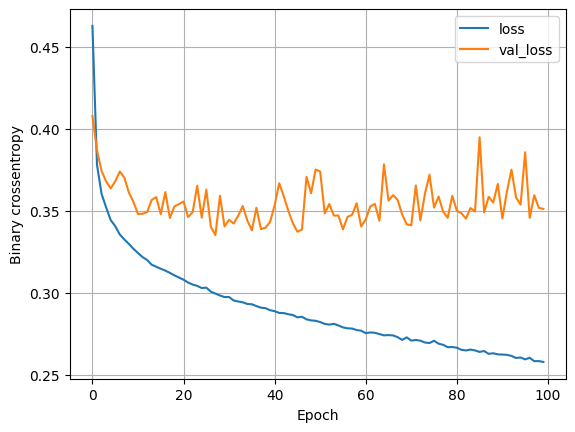

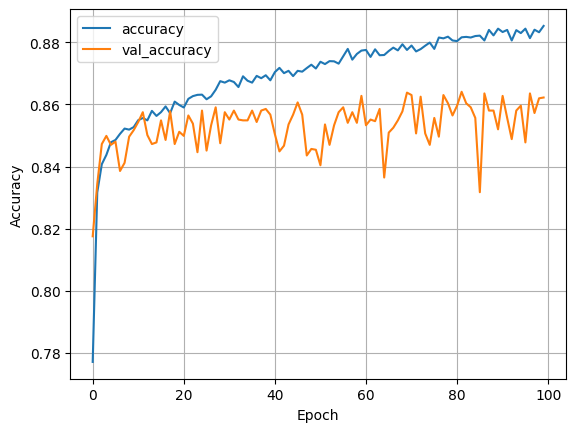

In [12]:
plot_loss(history)
plot_accuracy(history)

Let's wrap the training code inside a function so that we can more easily adjust the hyperparameters.

In [13]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs, validation_data):
    with tf.device("/GPU:0"):
        nn_model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(10,)),
            tf.keras.layers.Dense(num_nodes, activation="relu"),
            tf.keras.layers.Dropout(dropout_prob),
            tf.keras.layers.Dense(num_nodes, activation="relu"),
            tf.keras.layers.Dropout(dropout_prob),
            tf.keras.layers.Dense(1, activation="sigmoid") # our output will be in range 0 to 1
        ])

        nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="binary_crossentropy",
                        metrics=['accuracy'])

        history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)

        return nn_model, history

In [14]:
# Plot loss and accuracy side by side
def plot_loss_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['loss'], label="loss")
    ax1.plot(history.history['val_loss'], label="val_loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Binary crossentropy")
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label="accuracy")
    ax2.plot(history.history['val_accuracy'], label="val_accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)
    plt.show()

16 nodes, dropout 0, lr 0.01, batch_size 32


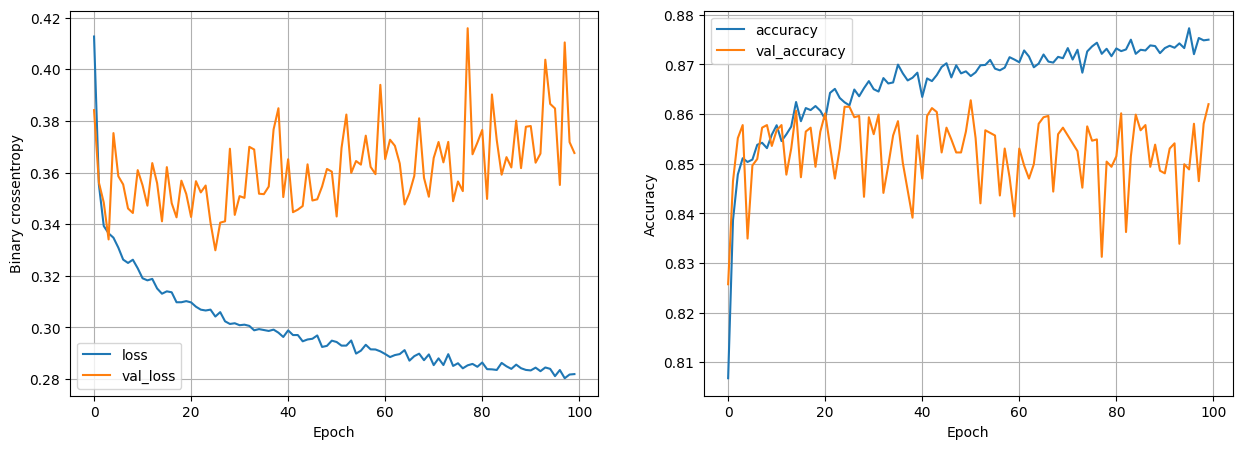

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8657 - loss: 0.3710
16 nodes, dropout 0, lr 0.01, batch_size 64


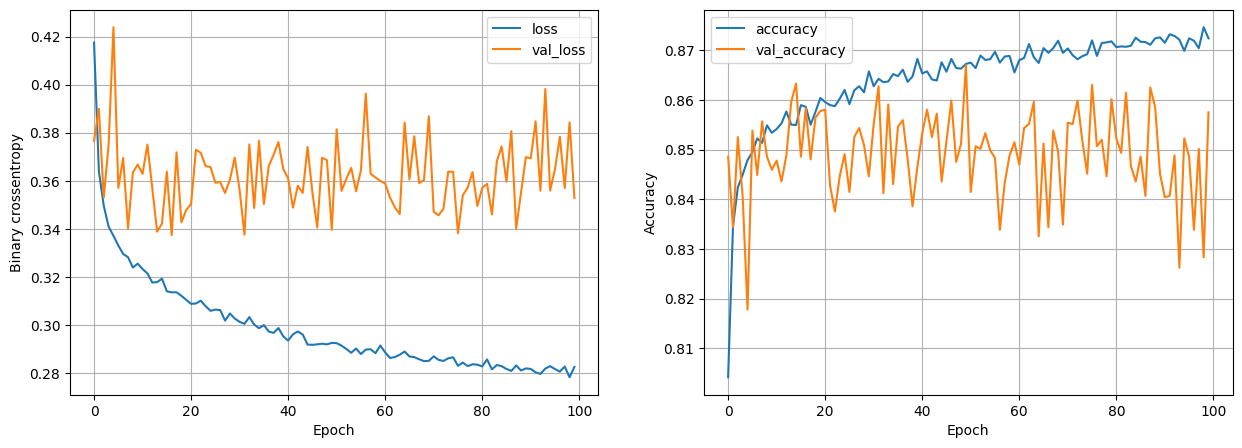

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8616 - loss: 0.3512
16 nodes, dropout 0, lr 0.01, batch_size 128


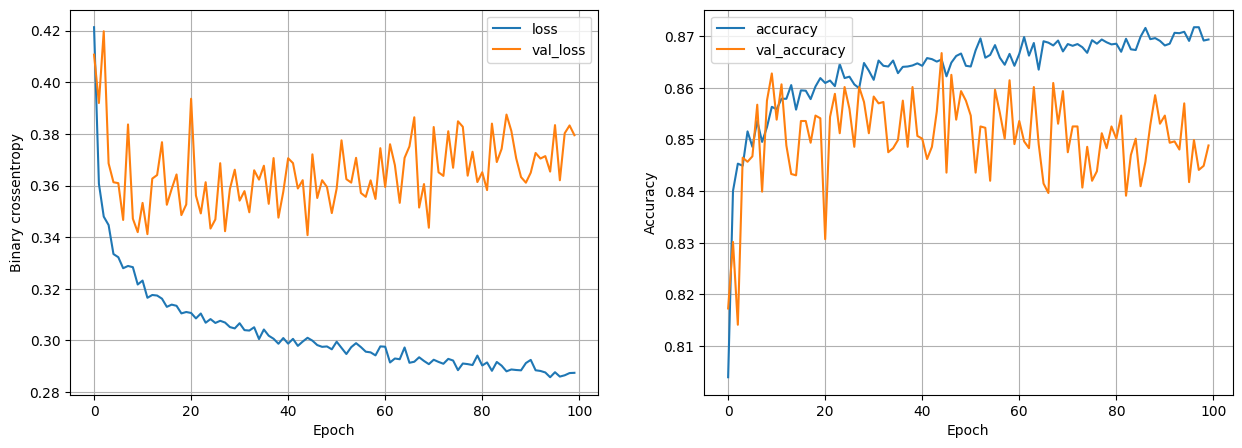

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8564 - loss: 0.3710
16 nodes, dropout 0, lr 0.001, batch_size 32


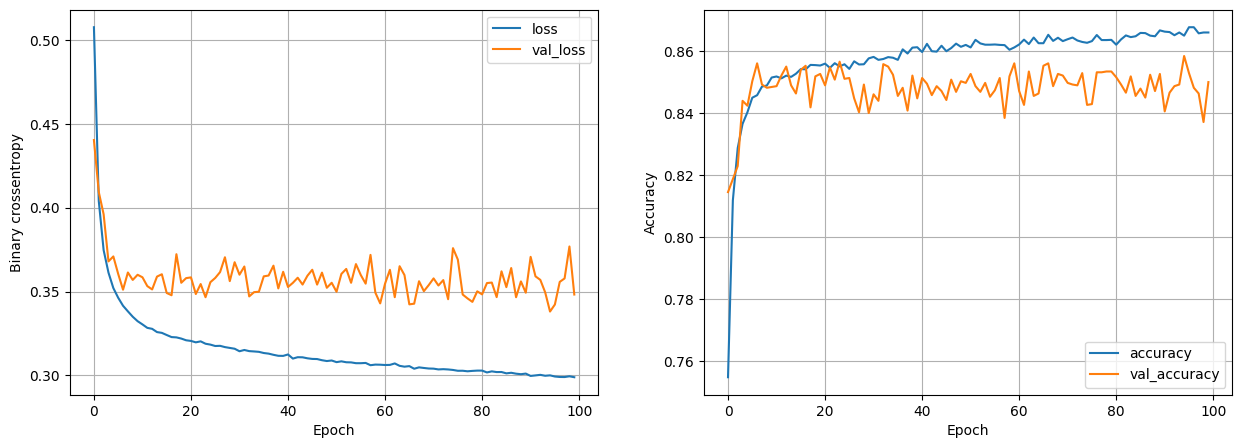

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8602 - loss: 0.3369
16 nodes, dropout 0, lr 0.001, batch_size 64


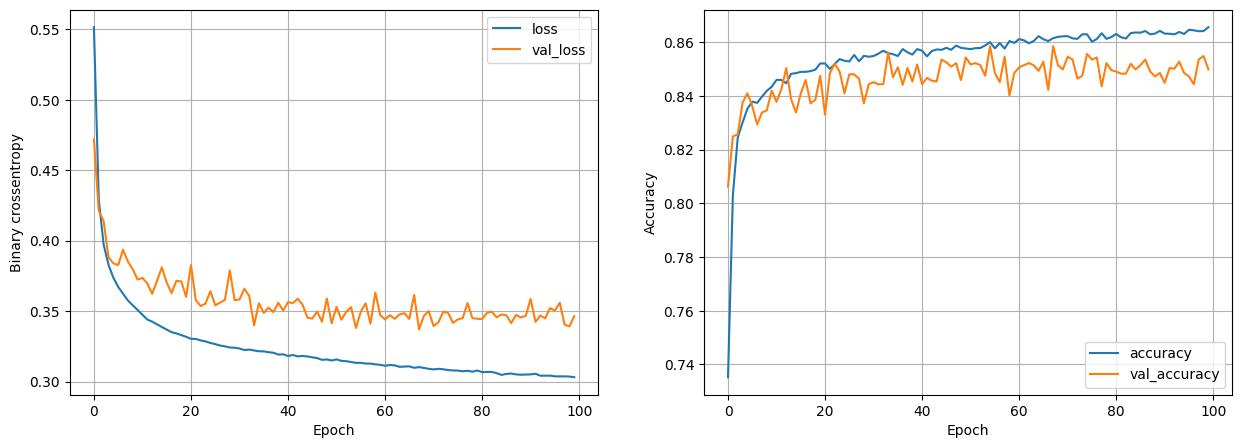

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8577 - loss: 0.3354
16 nodes, dropout 0, lr 0.001, batch_size 128


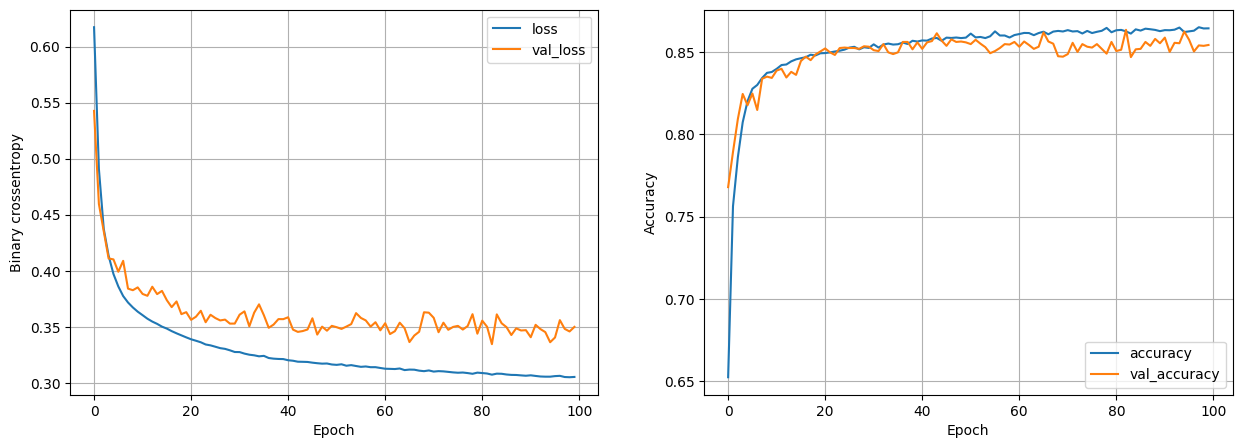

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8603 - loss: 0.3376
16 nodes, dropout 0.2, lr 0.01, batch_size 32


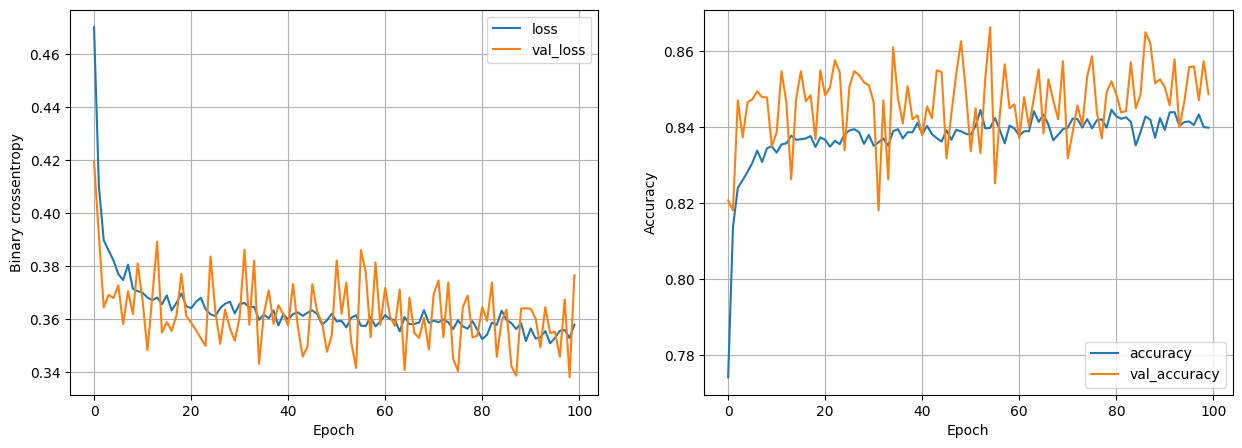

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8550 - loss: 0.3694
16 nodes, dropout 0.2, lr 0.01, batch_size 64


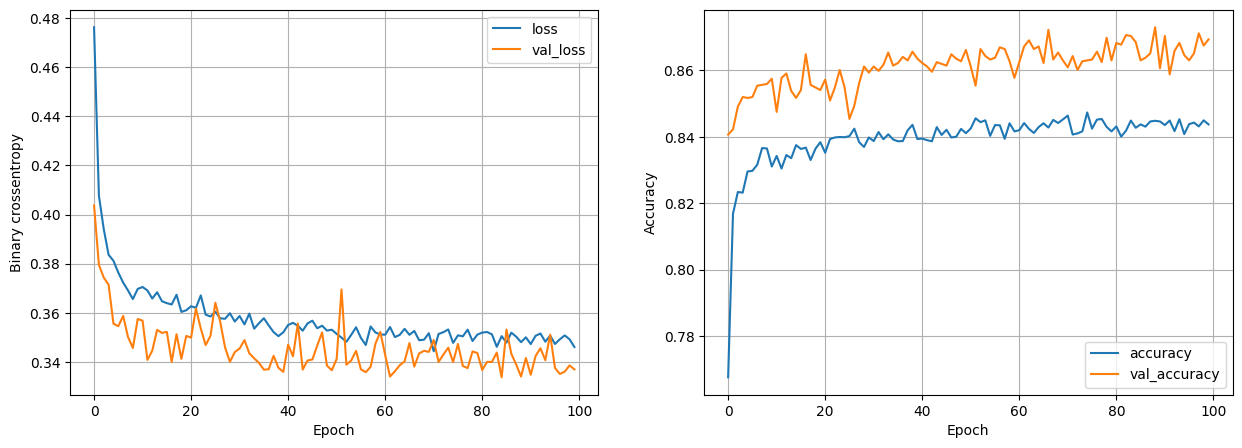

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8762 - loss: 0.3294
16 nodes, dropout 0.2, lr 0.01, batch_size 128


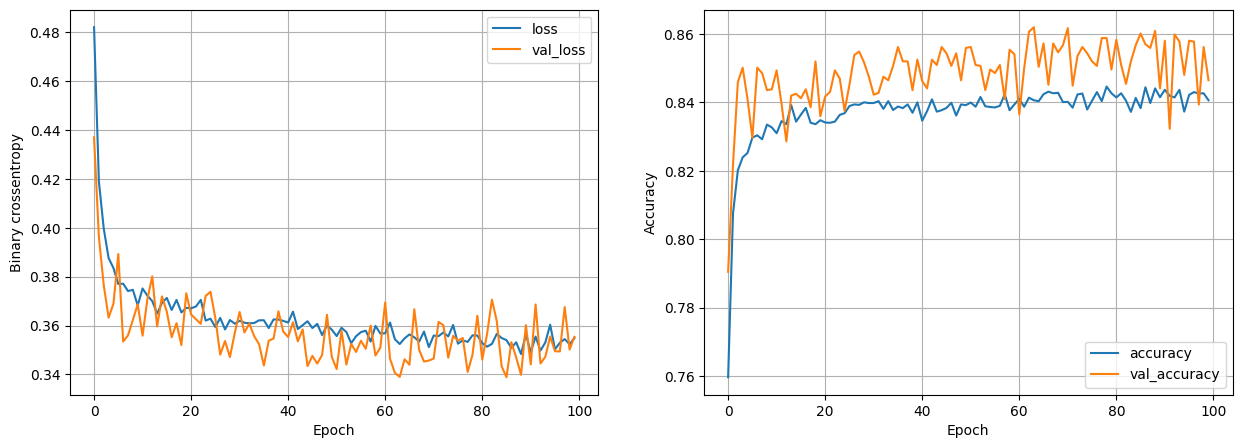

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8555 - loss: 0.3529
16 nodes, dropout 0.2, lr 0.001, batch_size 32


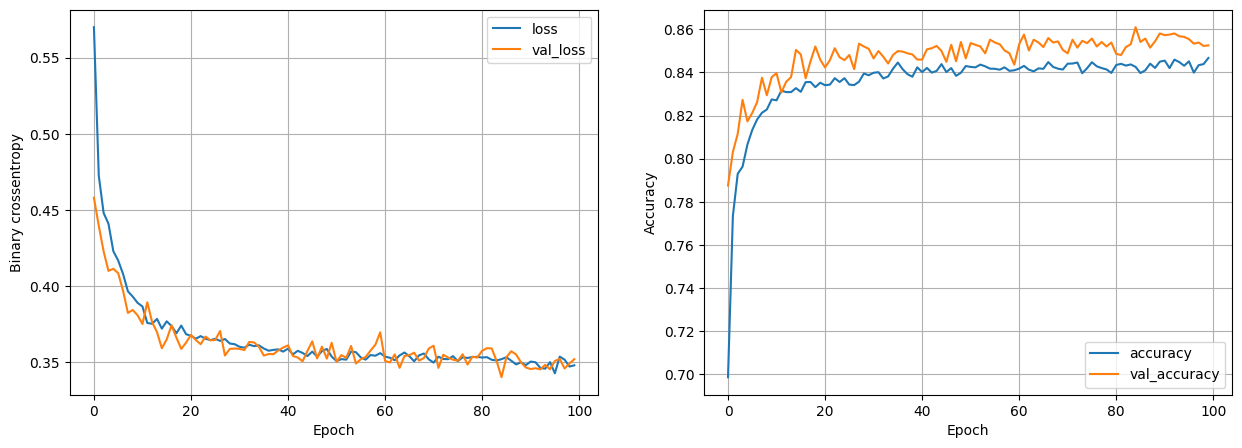

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8576 - loss: 0.3446
16 nodes, dropout 0.2, lr 0.001, batch_size 64


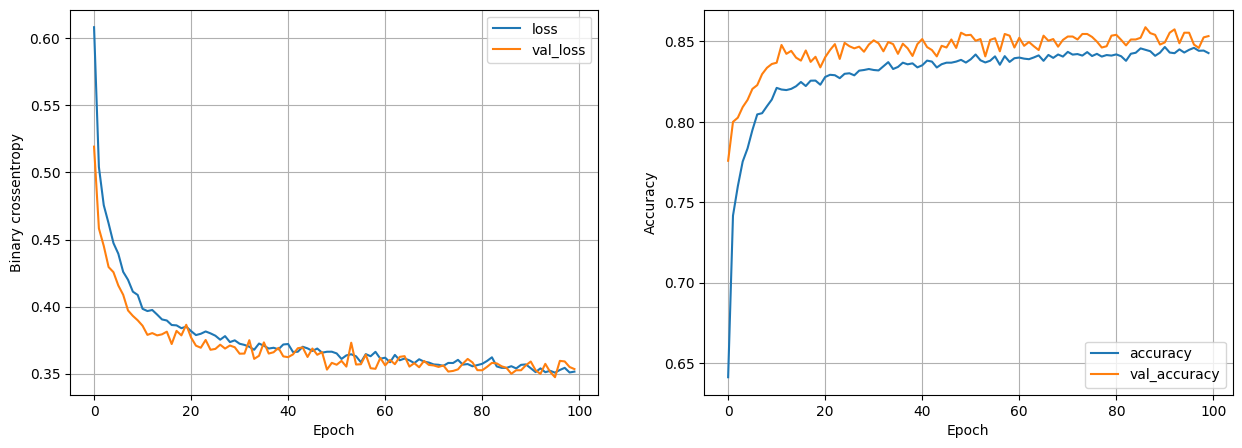

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8600 - loss: 0.3522
16 nodes, dropout 0.2, lr 0.001, batch_size 128


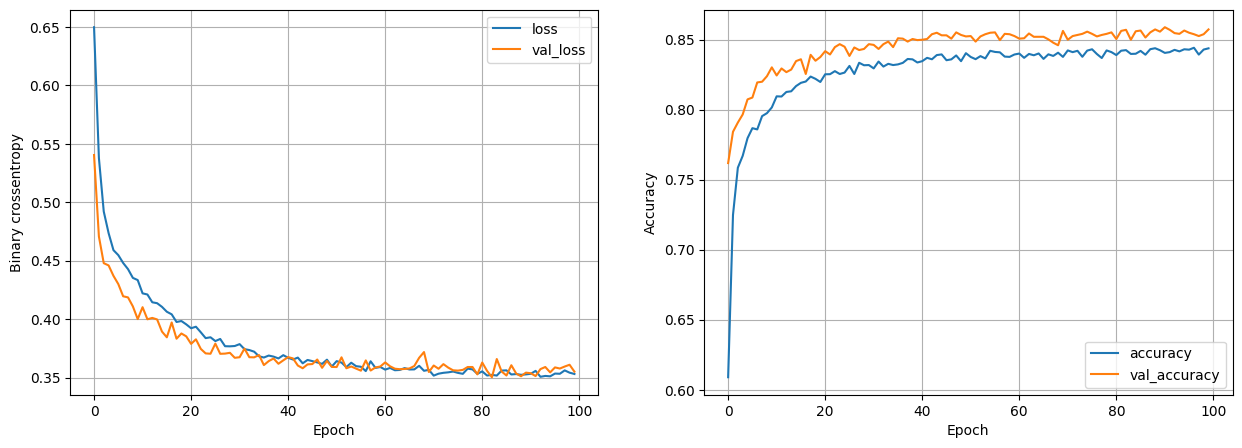

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8599 - loss: 0.3502
32 nodes, dropout 0, lr 0.01, batch_size 32


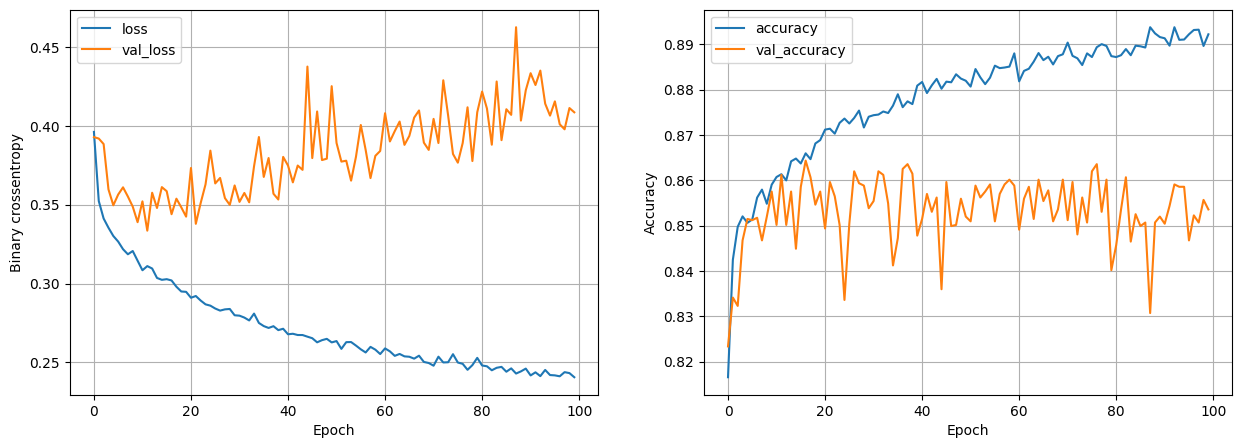

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8610 - loss: 0.3990
32 nodes, dropout 0, lr 0.01, batch_size 64


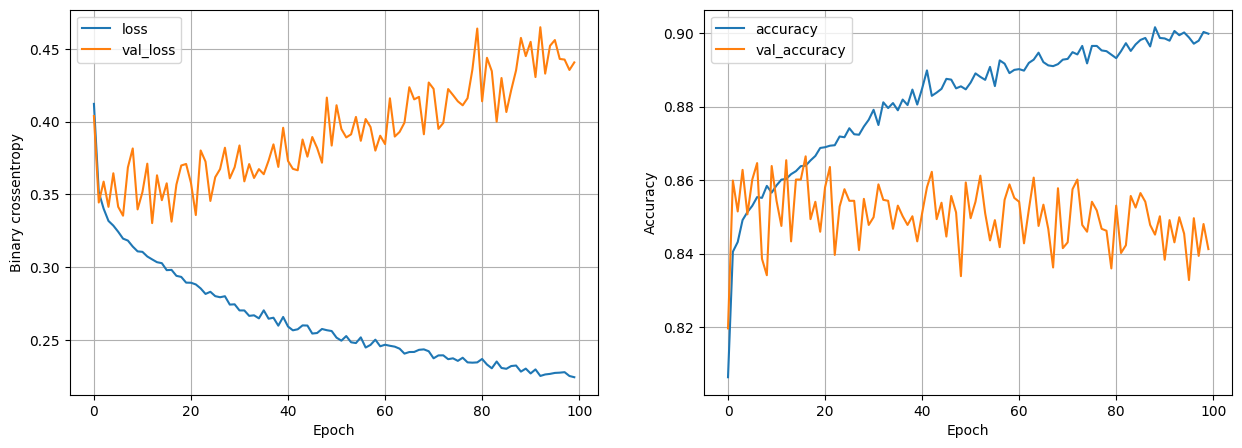

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8523 - loss: 0.4457
32 nodes, dropout 0, lr 0.01, batch_size 128


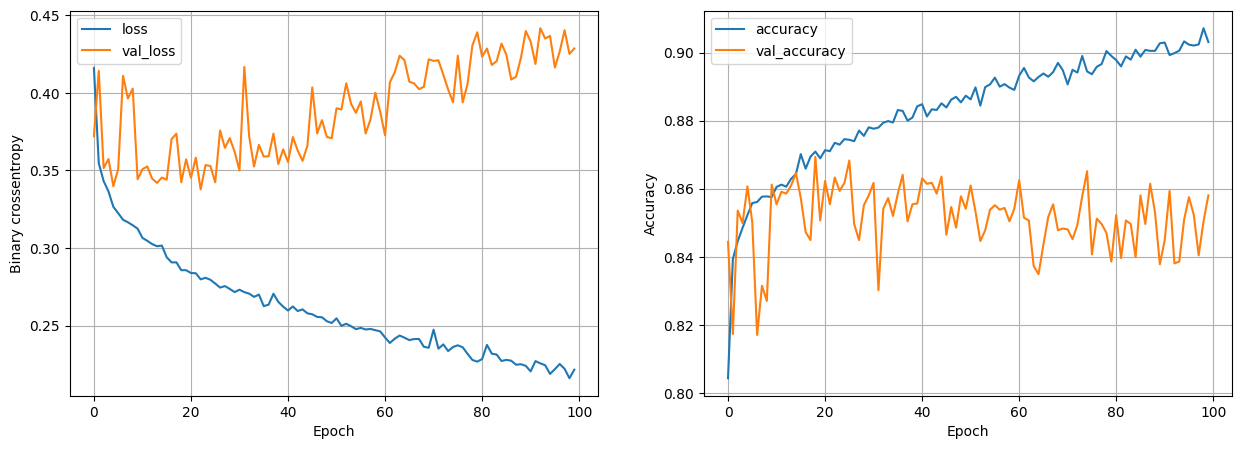

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8666 - loss: 0.4345
32 nodes, dropout 0, lr 0.001, batch_size 32


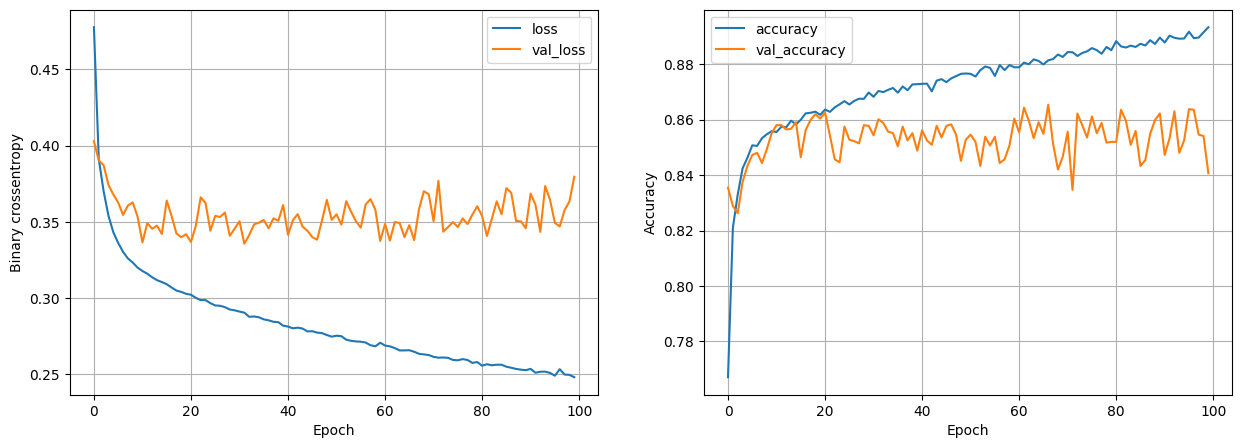

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8454 - loss: 0.3722
32 nodes, dropout 0, lr 0.001, batch_size 64


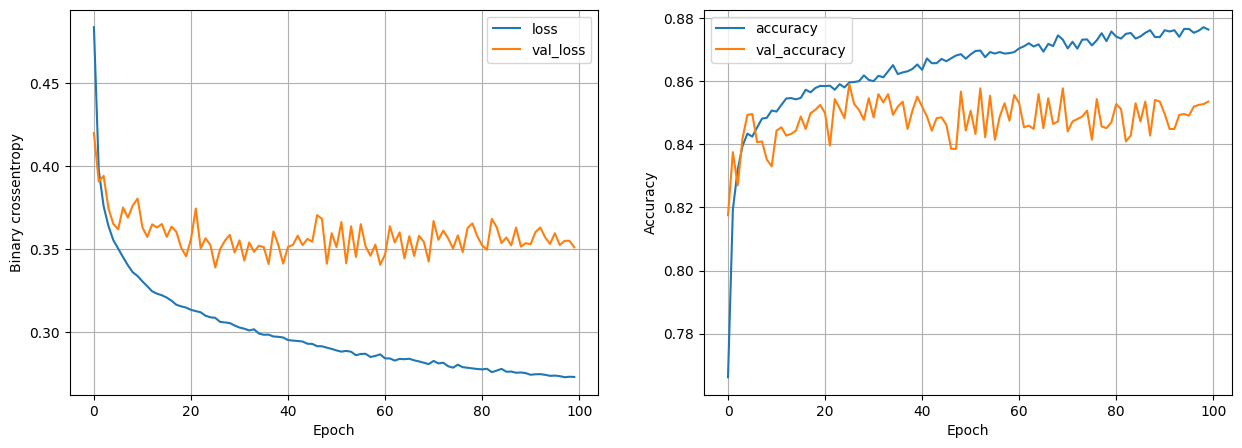

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8615 - loss: 0.3427
32 nodes, dropout 0, lr 0.001, batch_size 128


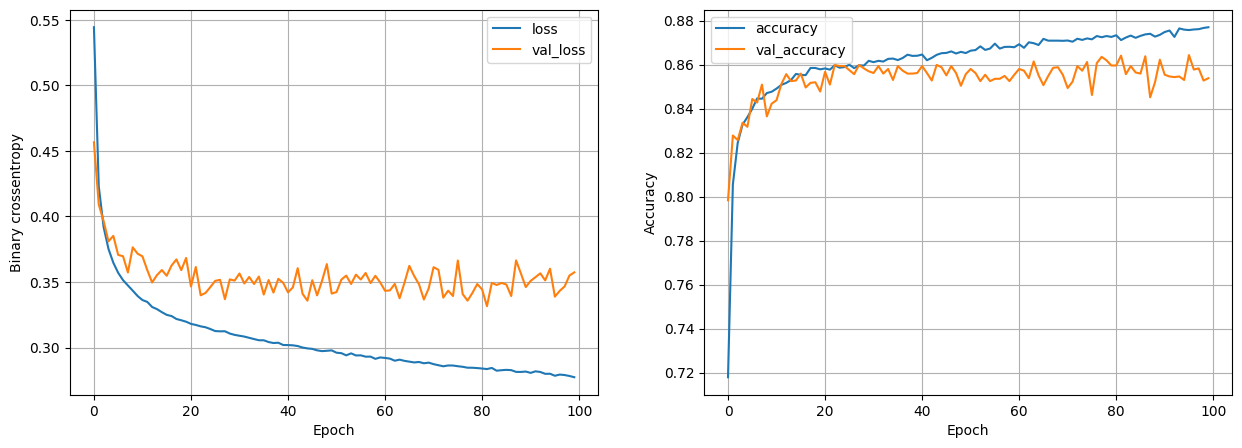

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8600 - loss: 0.3498
32 nodes, dropout 0.2, lr 0.01, batch_size 32


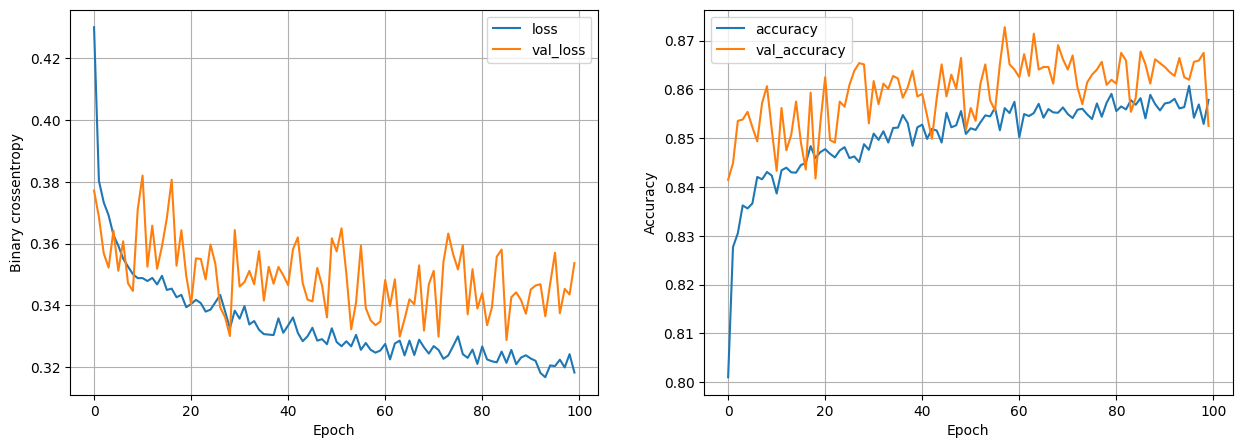

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8533 - loss: 0.3493
32 nodes, dropout 0.2, lr 0.01, batch_size 64


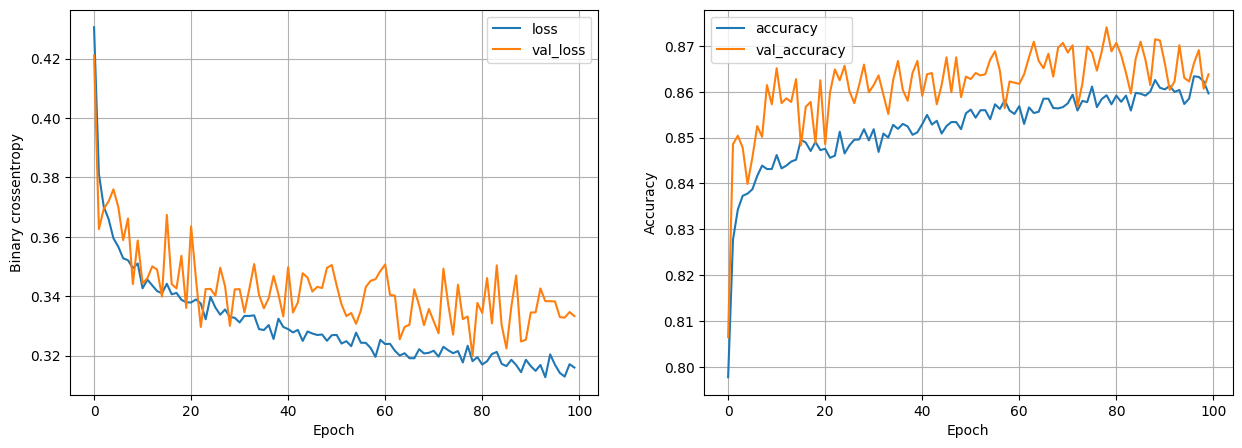

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8681 - loss: 0.3260
32 nodes, dropout 0.2, lr 0.01, batch_size 128


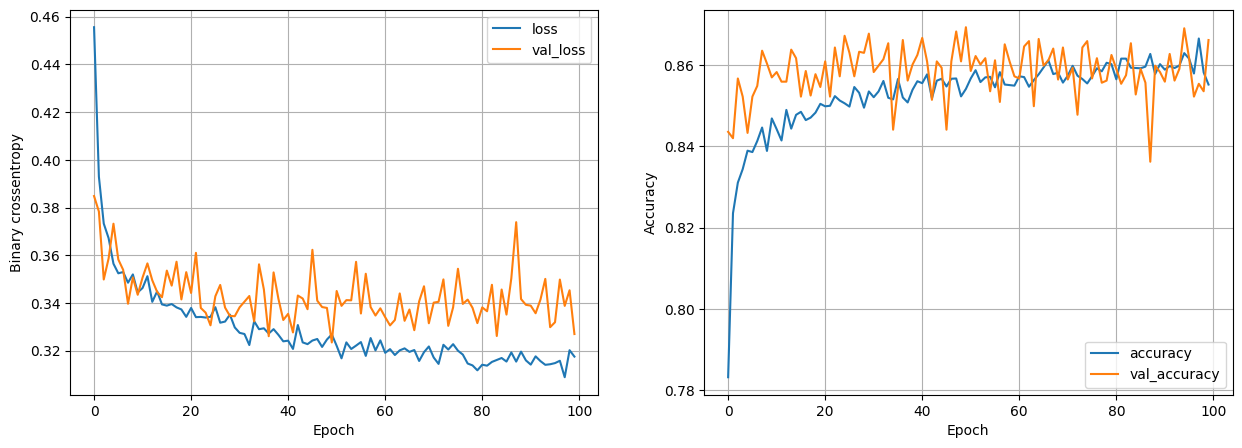

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8779 - loss: 0.3158
32 nodes, dropout 0.2, lr 0.001, batch_size 32


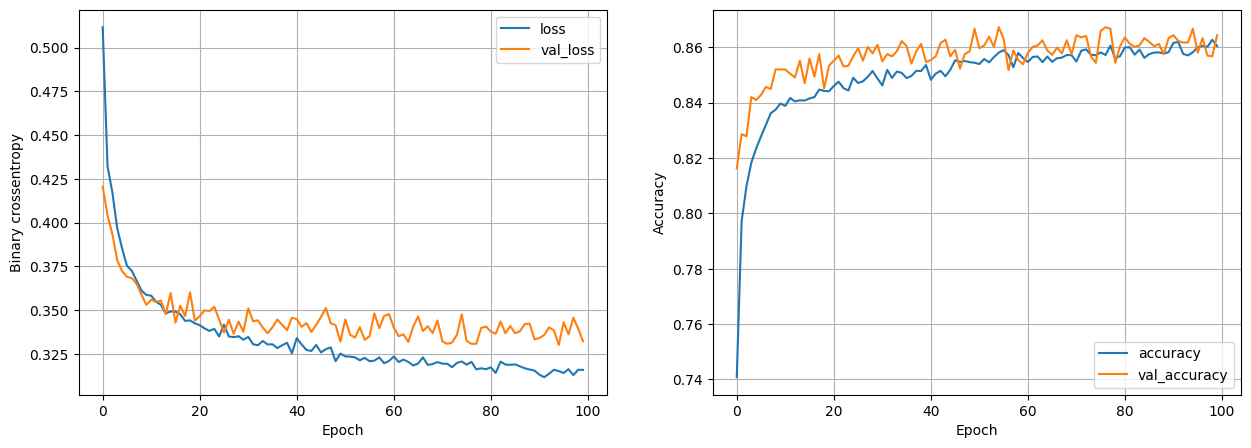

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8705 - loss: 0.3248
32 nodes, dropout 0.2, lr 0.001, batch_size 64


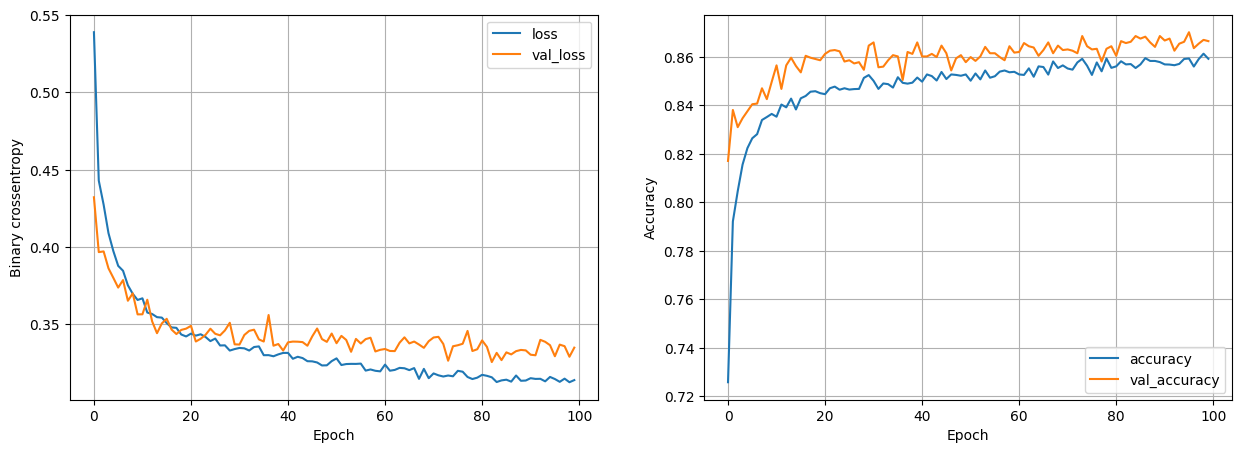

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8696 - loss: 0.3270
32 nodes, dropout 0.2, lr 0.001, batch_size 128


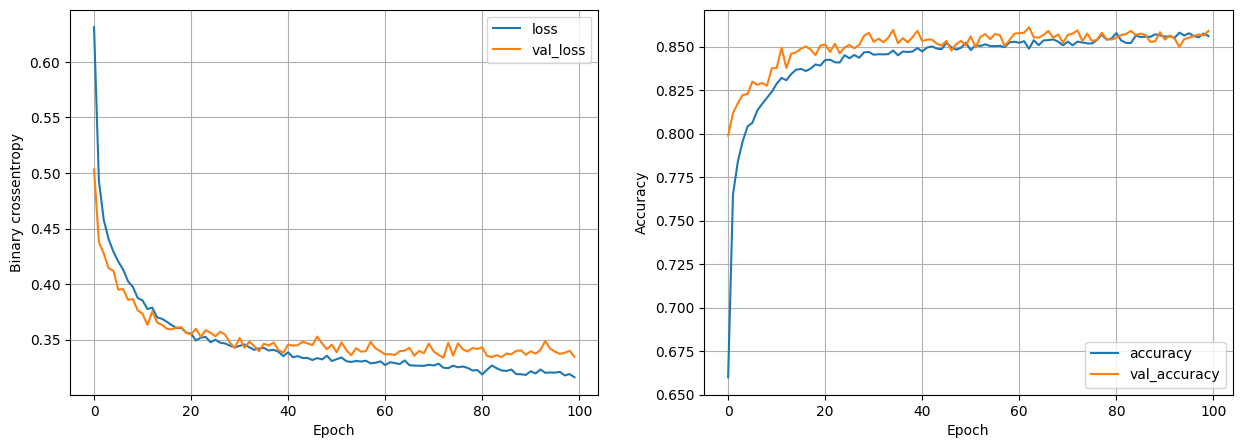

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8677 - loss: 0.3227
64 nodes, dropout 0, lr 0.01, batch_size 32


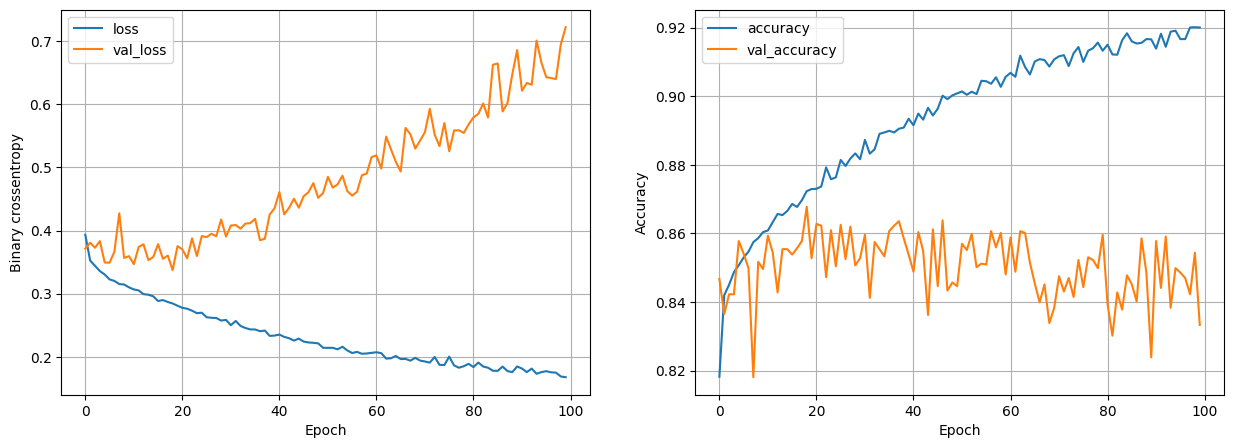

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8503 - loss: 0.7332
64 nodes, dropout 0, lr 0.01, batch_size 64


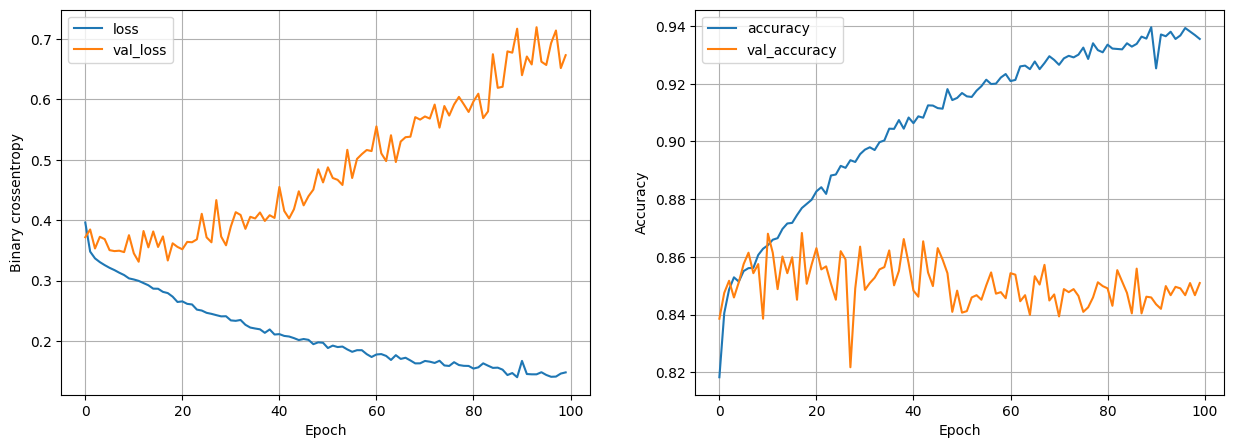

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8567 - loss: 0.6448
64 nodes, dropout 0, lr 0.01, batch_size 128


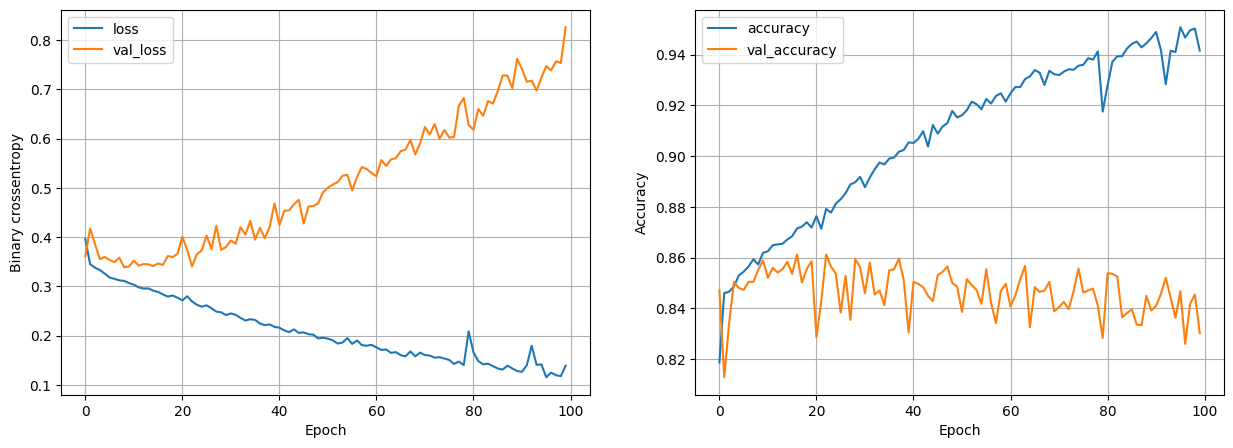

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8386 - loss: 0.8241
64 nodes, dropout 0, lr 0.001, batch_size 32


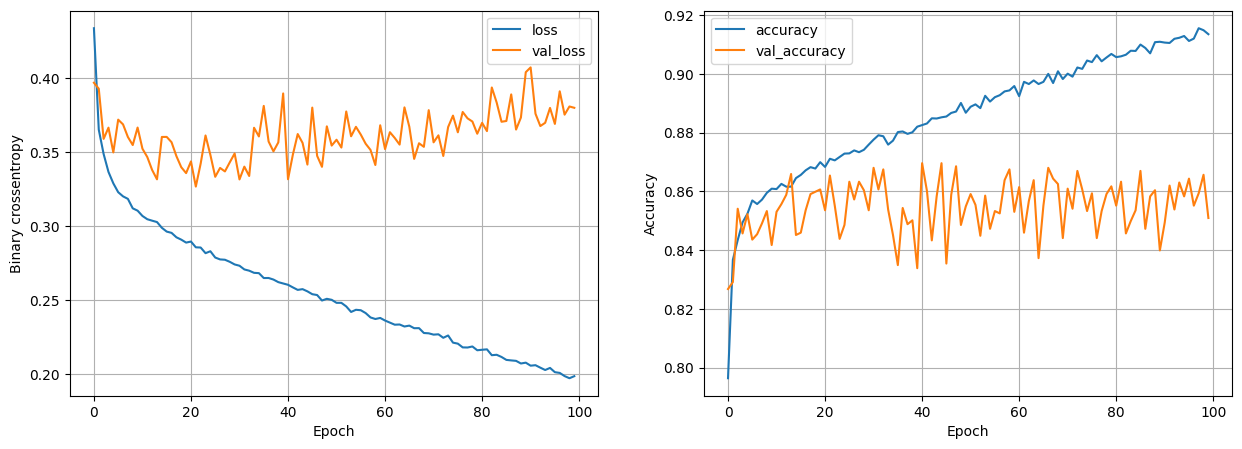

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8595 - loss: 0.3704
64 nodes, dropout 0, lr 0.001, batch_size 64


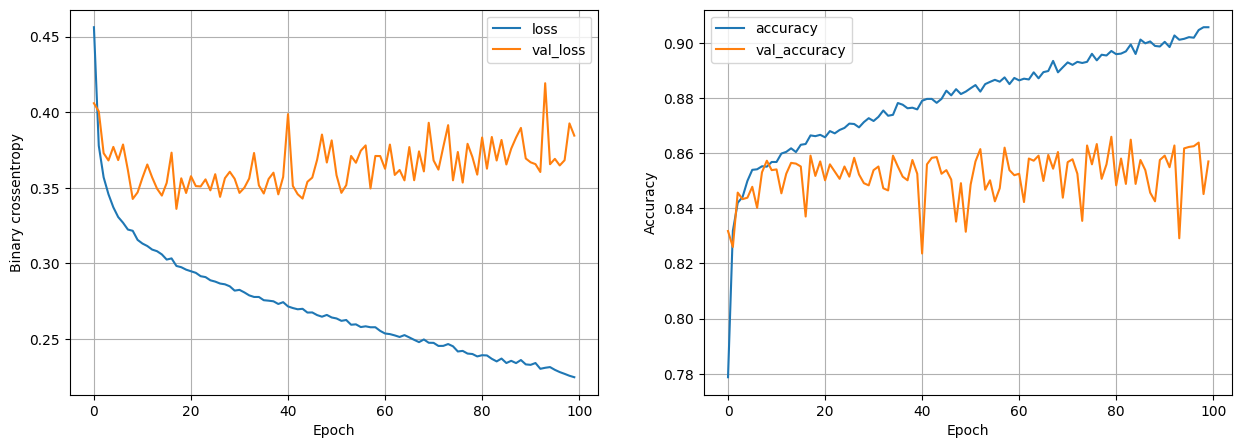

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8673 - loss: 0.3709
64 nodes, dropout 0, lr 0.001, batch_size 128


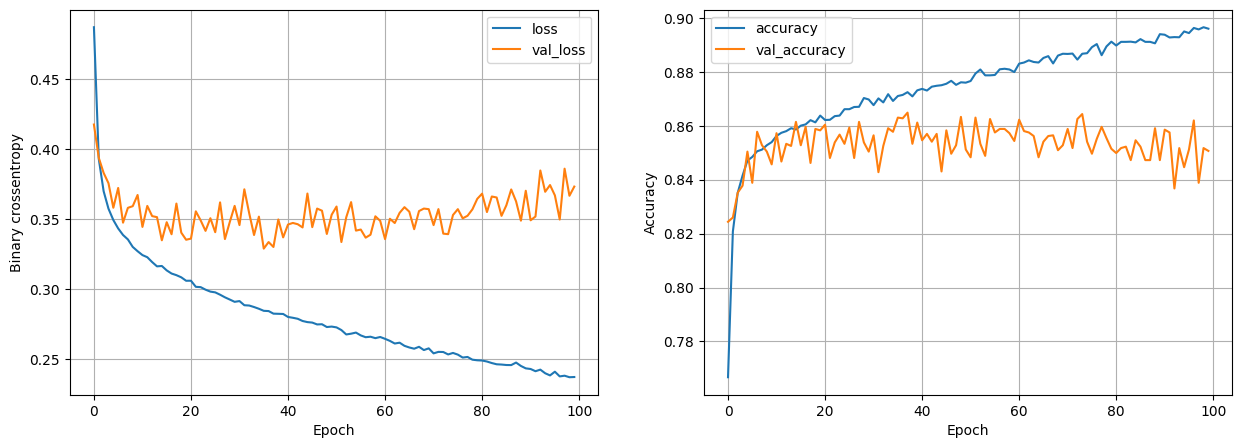

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8585 - loss: 0.3578
64 nodes, dropout 0.2, lr 0.01, batch_size 32


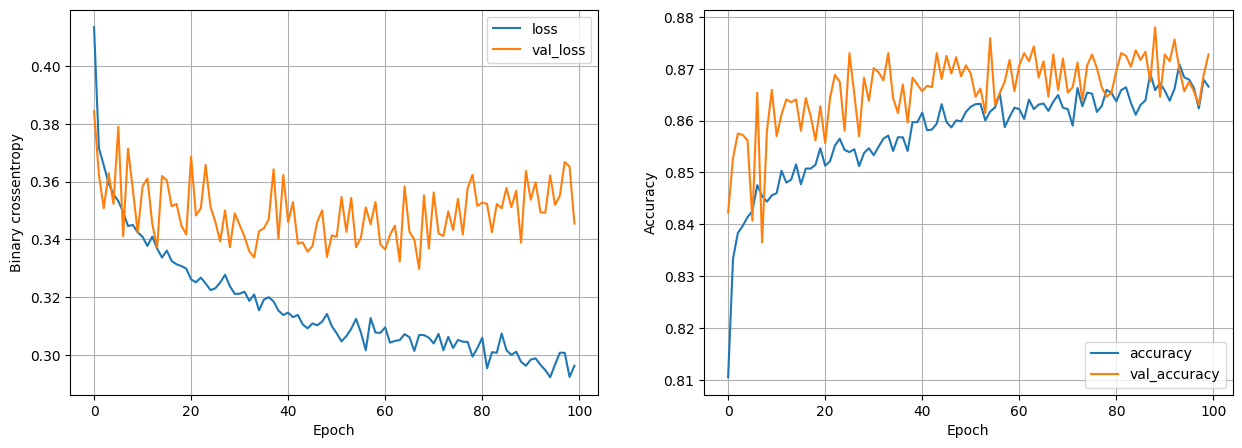

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8765 - loss: 0.3370
64 nodes, dropout 0.2, lr 0.01, batch_size 64


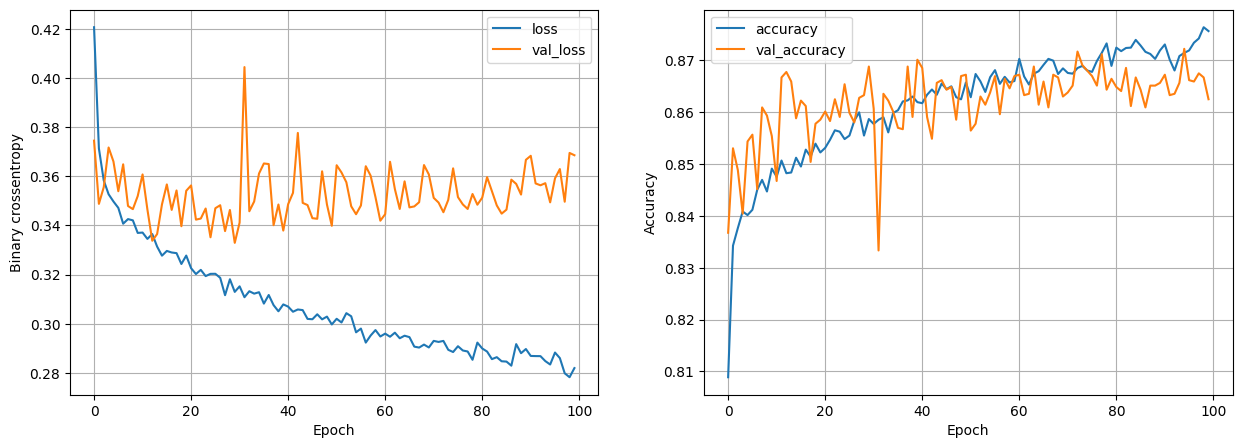

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8711 - loss: 0.3592
64 nodes, dropout 0.2, lr 0.01, batch_size 128


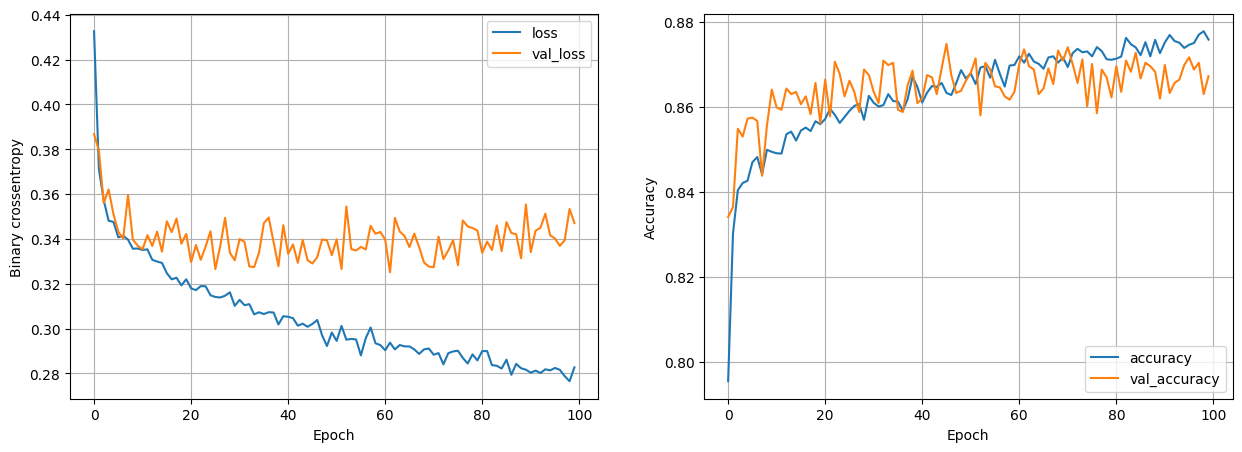

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8768 - loss: 0.3388
64 nodes, dropout 0.2, lr 0.001, batch_size 32


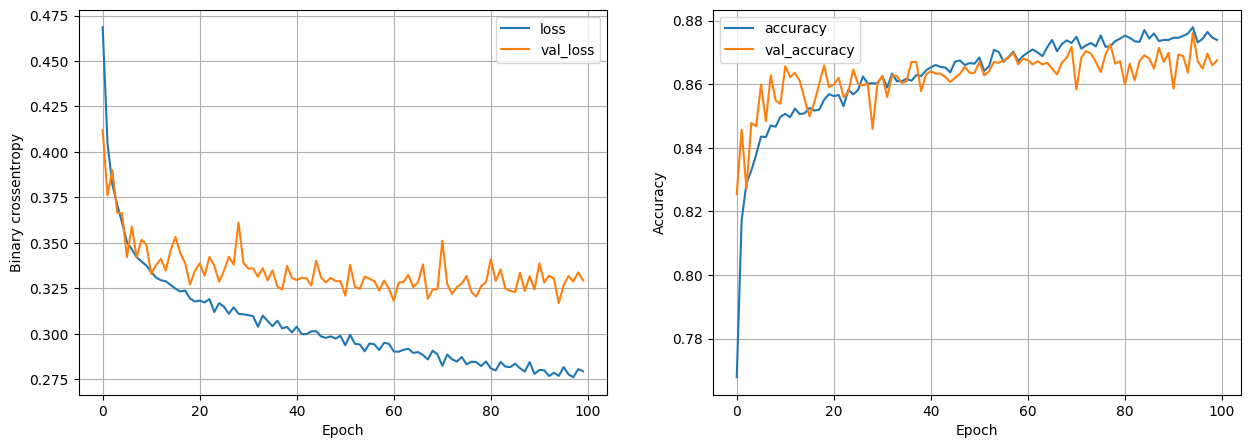

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8751 - loss: 0.3191
64 nodes, dropout 0.2, lr 0.001, batch_size 64


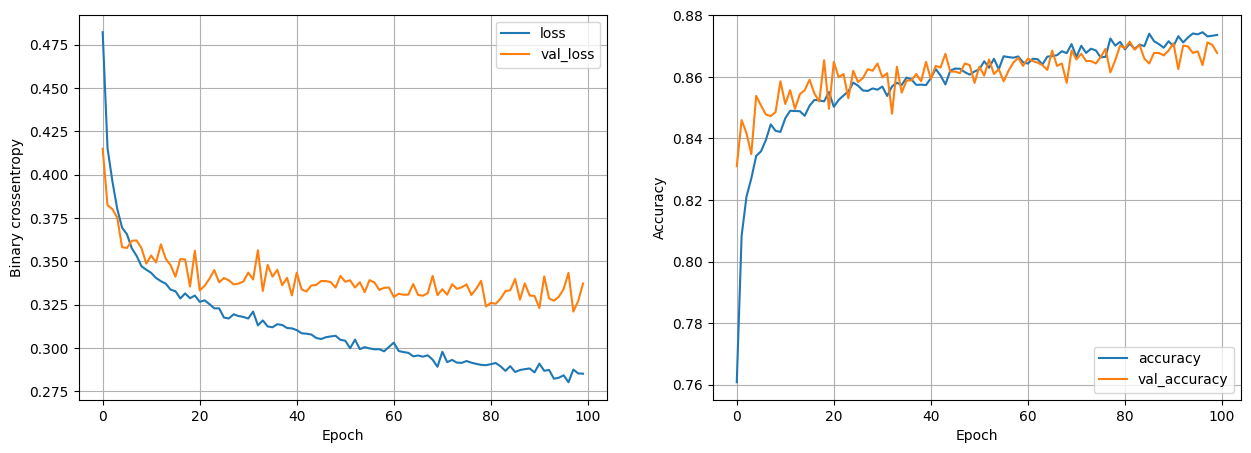

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8751 - loss: 0.3274
64 nodes, dropout 0.2, lr 0.001, batch_size 128


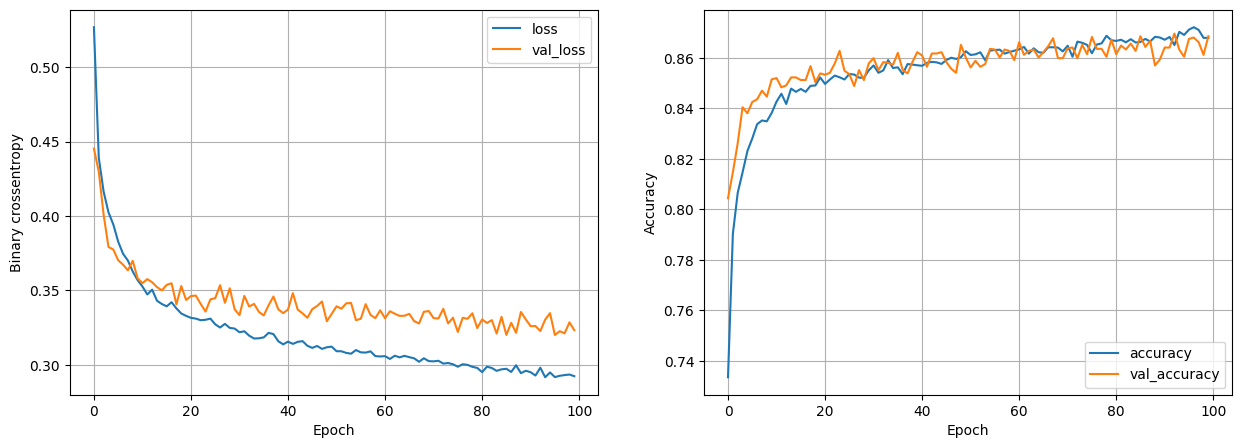

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8779 - loss: 0.3112


In [15]:
least_val_loss = float("inf")
least_loss_model = None

epochs = 100
for num_nodes in [16, 32, 64]:
    for dropout_prob in[0, 0.2]:
        for lr in [0.01, 0.001]:
            for batch_size in [32, 64, 128]:
                print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch_size {batch_size}")
                nn_model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs, (X_valid, y_valid))
                plot_loss_accuracy(history)
                val_loss = nn_model.evaluate(X_valid, y_valid)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = nn_model

Let's test out the model!

In [16]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,) # round all our data to either 0 or 1

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1302
           1       0.91      0.91      0.91      2502

    accuracy                           0.88      3804
   macro avg       0.87      0.86      0.87      3804
weighted avg       0.88      0.88      0.88      3804

